In [1]:
import string
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.inchi import MolToInchi

warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

In [2]:
data = pd.read_excel(r"6_isomeric_strip_salt.xlsx")
print(data.shape)
data.head()

(7417, 12)


,chemical_name,cas_number,smiles,VDss_L_kg,SD,fu_h,reference_number,Comments_1,Comments_2,t 1/2,smiles_supplementary,isomeric_smiles
0,(-)dOTC,160707-69-7,C1=CN(C2SC(OC2)CO)C(=O)N=C1N,1.18,NaN,NaN,R1,"PATRICK F. SMITH, ALAN FORREST, CHARLES H. BAL...",Dosed as 100 mg of racemate. (-) form called a...,NaN,C1=CN(C2SC(OC2)CO)C(=O)N=C1N,Nc1ccn(C2COC(CO)S2)c(=O)n1
1,(+)dOTC,160707-68-6,C1=CN(C2SC(OC2)CO)C(=O)N=C1N,0.84,NaN,NaN,R1,"PATRICK F. SMITH, ALAN FORREST, CHARLES H. BAL...",Dosed as 100 mg of racemate. (-) form called a...,NaN,C1=CN(C2SC(OC2)CO)C(=O)N=C1N,Nc1ccn(C2COC(CO)S2)c(=O)n1
2,1-Aminocyclopropanecarboxylic Acid,22059-21-8,C(=O)([O-])C([NH3+])(C1)C1,0.73,NaN,NaN,R1,"Cherkofsky, S.C. (1995) 1-Aminocyclopropylcarb...",NaN,NaN,C(=O)([O-])C([NH3+])(C1)C1,NC1(C(=O)O)CC1
3,5-Hydroxymethyl tolterodine,207679-81-0,c1ccc(C(CC[NH+](C(C)C)C(C)C)c(c(O)c2)cc(CO)c2)cc1,2.41,NaN,NaN,R1,PDR reference on fesoterodine. Accessed July 1...,"After oral administration, fesoterodine is wel...",NaN,c1ccc(C(CC[NH+](C(C)C)C(C)C)c(c(O)c2)cc(CO)c2)cc1,CC(C)N(CCC(c1ccccc1)c1cc(CO)ccc1O)C(C)C
4,619C89,130800-90-7,Clc1c(cc(cc1c(cnc2N3CC[NH+](C)CC3)c(N)n2)Cl)Cl,15.31,NaN,NaN,R1,"A. J. MERCER, R. J. LAMB, HUSSEIN, S. HOBBIGER...",Data digitized from reported plot. 1 mg/kg onl...,NaN,Clc1c(cc(cc1c(cnc2N3CC[NH+](C)CC3)c(N)n2)Cl)Cl,CN1CCN(c2ncc(-c3cc(Cl)cc(Cl)c3Cl)c(N)n2)CC1


In [3]:
# These commands remove redundant columns and redefine column names.
delete_columns = ['smiles', 'smiles_supplementary']
columns_list = ['chemical_name', 'cas_number', 'VDss_L_kg', 'SD', 'fu_h',
                'reference_number', 'Comments_1', 'Comments_2', 't 1/2', 'smiles']

data.drop(delete_columns, axis=1, inplace=True)
data.columns = columns_list

In [4]:
def product_inchi(df):
    """This function generate InChI."""
    for smiles, i in zip(df["smiles"], range(df.shape[0])):
        # noinspection PyBroadException
        try:
            # convert from smiles to InChI
            mol = Chem.MolFromSmiles(smiles)
            inchi = MolToInchi(mol)
            df.loc[i, 'Inchi'] = inchi
        except:
            # delete data that doesn't generate InChI correctly
            df = df.drop(i)
    # update index
    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
def filter_repeat(col, column, descriptors):
    """This function pads columns of data."""
    j = 0
    # update index
    descriptors.index = range(descriptors.shape[0])
    df = pd.DataFrame(columns=descriptors.columns)
    # complement other columns in order
    for value in col:
        for i in range(len(descriptors)):
            if value == descriptors.loc[i, column]:
                df.loc[j] = descriptors.loc[i]
                j += 1
    
    return df

In [6]:
def devide(descriptors):
    """This equation separates repeated and non-repeating data."""
    df = descriptors.copy()
    column = 'Inchi'
    # count the InChI kinds and their corresponding numbers
    count_column = dict(Counter(df[column]))
    features_u = pd.DataFrame(columns=df.columns)
    features_r = pd.DataFrame(columns=df.columns)
    # put the duplicate and non-duplicated InChI columns into two tables in order
    features_u[column] = [key for key, value in count_column.items() if value == 1]
    features_r[column] = [key for key, value in count_column.items() if value > 1]
    # complete other columns
    get_unique = filter_repeat(features_u[column], column, df)
    get_repeat = filter_repeat(features_r[column], column, df)
    print("VDss repeat size: ", get_repeat.shape)
    
    return get_unique, get_repeat

In [7]:
def choice_feature(df):
    """This function removes duplicate data."""
    value = []
    r = j = c = 0
    col = 'Inchi'
    final_features = pd.DataFrame(columns=df.columns)
    # find duplicate data in turn
    while r + 1 < df.shape[0]:
        while r + 1 < df.shape[0] and df.loc[r + 1, col] == df.loc[r, col]:
            value.append(df.loc[r, 'VDss_L_kg'])
            r += 1
        # save the set of duplicate data to another table
        df1 = df.loc[:r]
        # delete this set of data
        df.drop(range(r + 1), axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
        # noinspection PyBroadException
        try:
            # find the VDss value with the most occurrences
            value_appear = max(value, key=lambda v: value.count(v))
            # find the row index corresponding to the VDss value
            choice = value.index(value_appear)
            # keep the row information corresponding to the most occurrences of VDss
            final_features.loc[j] = df1.loc[choice]
            j += 1
        except:
            c += 1
        value = []
        r = 0
    print("unable to determine the total groups of number of VDss values: ", c)
    
    return final_features

In [8]:
def MW_LOGP(df):
    """This function adds mw and logP information to excel file."""
    for smiles, i in zip(df["smiles"], range(df.shape[0])):
        # noinspection PyBroadException
        try:
            # generate molecular weight and logP
            mol = Chem.MolFromSmiles(smiles)
            df.loc[i, 'MW'] = Descriptors.MolWt(mol)
            df.loc[i, 'LOGP'] = Descriptors.MolLogP(mol)
        except:
            df.drop(i, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [9]:
def logVDss(df):
    """This function adds logVDss information to excel file."""
    df['VDss_L_kg'] = df['VDss_L_kg'].astype(float)
    for y, i in zip(df["VDss_L_kg"], range(df.shape[0])):
        # delete the data with VDss equal to 0
        if y == 0:
            df.drop(i, axis=0, inplace=True)
        else:
            # convert logVDss to logVDss
            df.loc[i, 'logVDss'] = np.log10(y)
    df.reset_index(drop=True, inplace=True)
    return df

In [10]:
def CDF(df1, upper, lower, column, label):
    """This function removes too large and too small data and plots the cumulative distribution function of the remaining data."""    
    df = df1.copy()
    # delete data larger than upper and smaller than lower
    for i, j in zip(df[column], range(len(df[column]))):
        if i > upper:
            df.drop(j, axis=0, inplace=True)
        elif i < lower:
            df.drop(j, axis=0, inplace=True)
    # update index
    df.reset_index(drop=True, inplace=True)
    sample = df[column]
    ecdf = sm.distributions.ECDF(sample)
    # define x-axis data
    x = np.linspace(min(sample), max(sample))
    y = ecdf(x)

    ax = plt.subplot(1, 1, 1)
    # set the labels and font size of the x and y axes
    ax.set_xlabel(label, font)
    ax.set_ylabel('probability', font)
    # output data dimension
    print("dimension of current data: ", df.shape)
    # set the figure title as well as the title font and size
    ax.set_title(column and 'Cumulative Distribution function', font)
    # set tick label size
    plt.tick_params(labelsize=labelsize)
    # set the font of the x-axis and y-axis tick values
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    # draw a ladder diagram
    plt.step(x, y)
    plt.show()
    
    return df

In [11]:
def box(df):
    """This function draws the boxplot of the data."""    
    plt.figure(figsize=(15, 6))
    column_list = ['MW', 'LOGP', 'logVDss']
    label_list = ['MW', 'logP', 'logVD$_{ss}$']
    
    for i, column, label_name in zip(range(1, 4), column_list, label_list):
        box_ax = plt.subplot(1, 3, i)
        # draw the boxplot
        box_ax.boxplot(df[column])
        # set the x-axis tick labels
        box_ax.set_xticklabels([label_name])
        # set the label and font size of the y-axis
        box_ax.set_ylabel('Value', font)
        # set tick label font size
        plt.tick_params(labelsize=labelsize)
        # set the font of the x-axis and y-axis tick values
        labels = box_ax.get_xticklabels() + box_ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]

    # set the spacing between graphs
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

In [12]:
def draw_scatter(df):
    """This function draws the scatter of the data."""
    plt.figure(figsize=(15, 6))
    column_list = ['MW', 'LOGP', 'logVDss']
    label_list = ['MW', 'logP', 'logVD$_{ss}$']
    color_list = ['red', 'blue', 'green']
    
    for i, column, label_name, color in zip(range(1, 4), column_list, label_list, color_list):
        scatter_ax = plt.subplot(1, 3, i)
        # draw the scatter
        scatter_ax.scatter(df[column], df[column], c=color)
        # set the labels and font size of the x and y axes
        scatter_ax.set_xlabel(label_name, font)
        scatter_ax.set_ylabel('Value', font)
        # set tick label font size
        plt.tick_params(labelsize=labelsize)
        # set the font of the x-axis and y-axis tick values
        labels = scatter_ax.get_xticklabels() + scatter_ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]

    # set the spacing between graphs
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

In [13]:
if __name__ == "__main__":
    # adds InChI information
    data = product_inchi(data)
    # divide data into two tables: duplicate data and non-duplicate data
    unique, repeat = devide(data)
    # deduplication
    final_data = choice_feature(repeat)
    # merge deduplicated data and deduplicated data
    final_data = pd.concat([unique, final_data])
    # updata index
    final_data.index = range(final_data.shape[0])

    # add MW and logVDss column
    data = final_data.copy()
    data = MW_LOGP(data)
    data = logVDss(data)

VDss repeat size:  (6114, 11)
unable to determine the total groups of number of VDss values:  0


In [14]:
# save file
data.to_excel("6_unique_data.xlsx", index=False)

In [15]:
# parameter assignment
font = {'family': 'Times New Roman',
        'size': 14}
labelsize = 14
fontsize = 14
x_coordinate = -0.1
y_coordinate = 1.05
wspace = 0.3
hspace = 0.2

In [16]:
print("size of data before outlier removal: ", data.shape)

size of data before outlier removal:  (2865, 14)


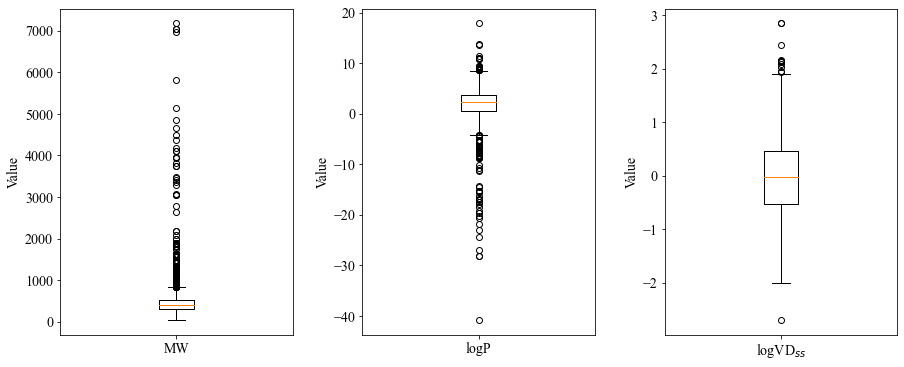

In [17]:
# boxplot of initial data
box(data)

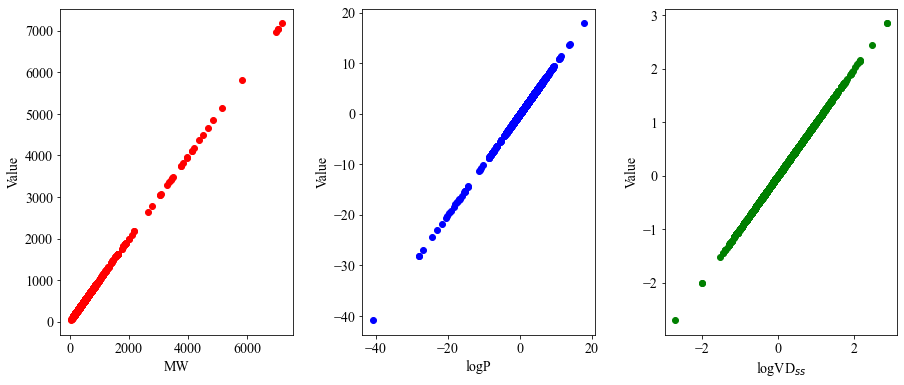

In [18]:
# scatter of initial data
draw_scatter(data)

dimension of current data:  (2527, 14)


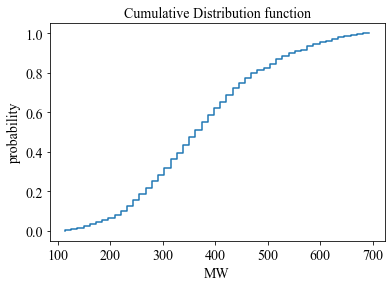

In [19]:
# cumulative distribution function plot after removing MW outliers
MW_delete = CDF(data, 700, 110, 'MW', 'MW')

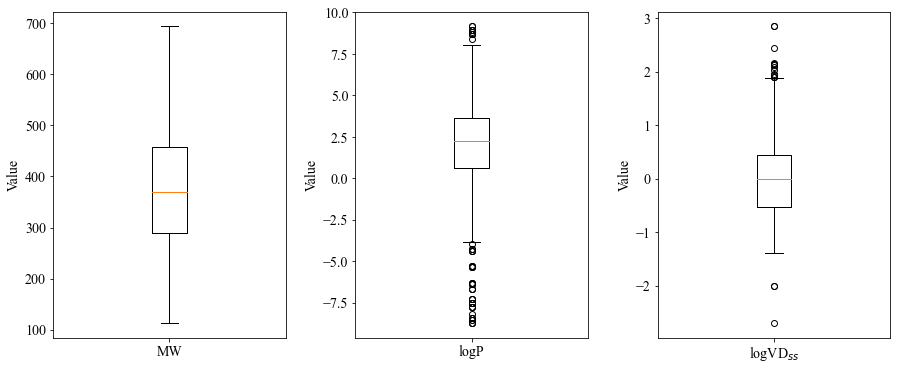

In [20]:
# boxplot after removing MW outliers
box(MW_delete)

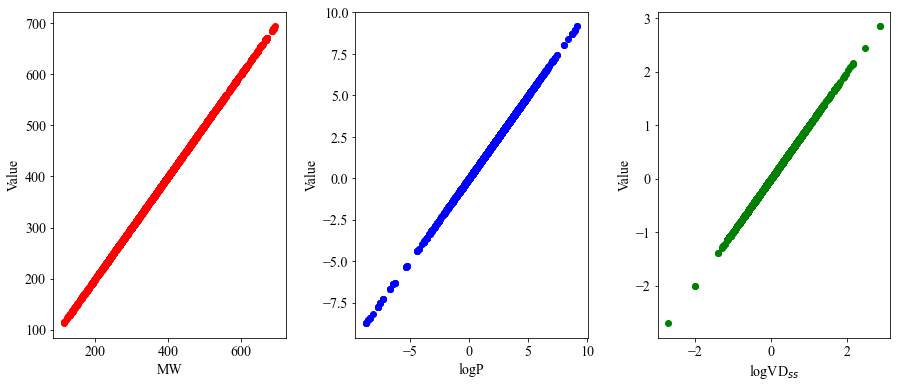

In [21]:
# scatter after removing MW outliers
draw_scatter(MW_delete)

dimension of current data:  (2458, 14)


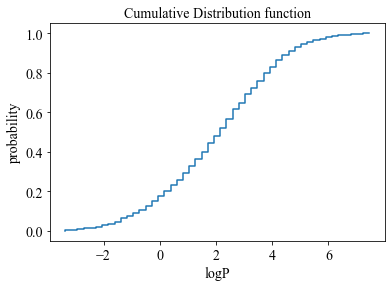

In [22]:
# cumulative distribution function plot after removing logP outliers
MW_LOGP_delete = CDF(MW_delete, 7.5, -3.5, 'LOGP', 'logP')

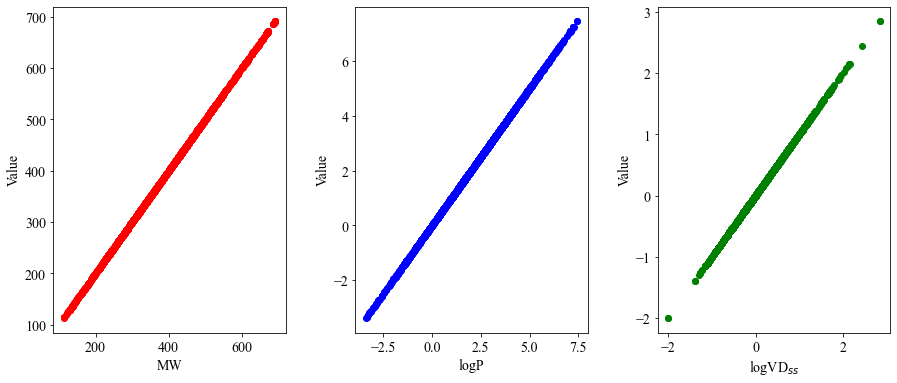

In [23]:
# scatter after removing logP outliers
draw_scatter(MW_LOGP_delete)

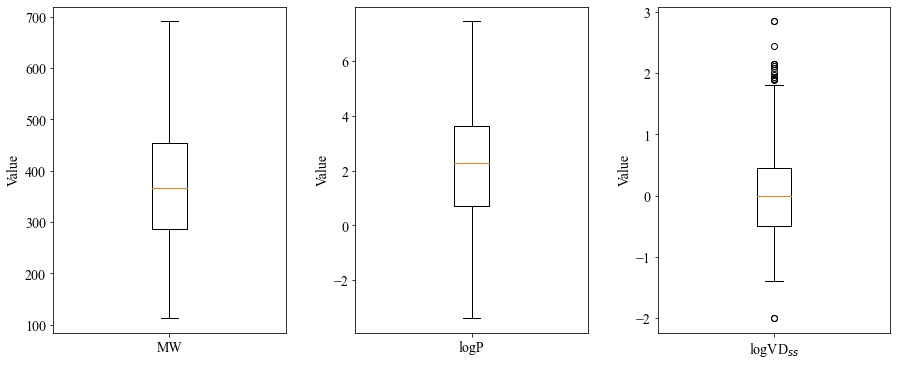

In [24]:
# boxplot after removing logP outliers
box(MW_LOGP_delete)

dimension of current data:  (2440, 14)


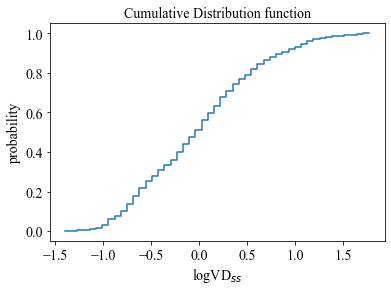

In [25]:
# cumulative distribution function plot after removing logVDss outliers
MW_LOGP_logVDss_delete = CDF(MW_LOGP_delete, 1.8, -1.5, 'logVDss', 'logVD$_{ss}$')

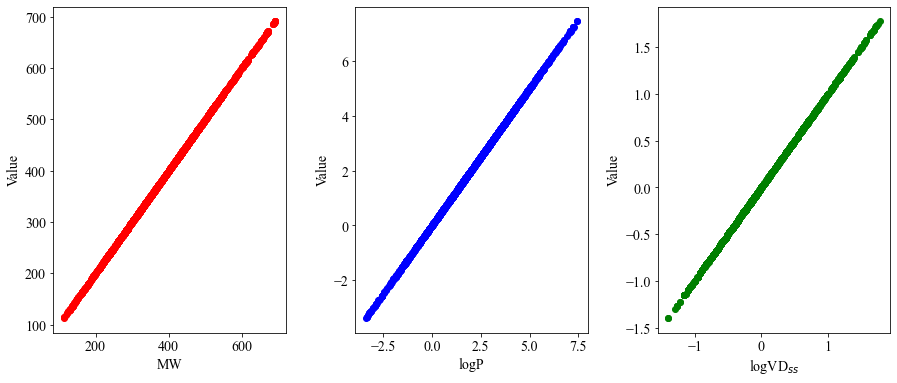

In [26]:
# scatter after removing logVDss outliers
draw_scatter(MW_LOGP_logVDss_delete)

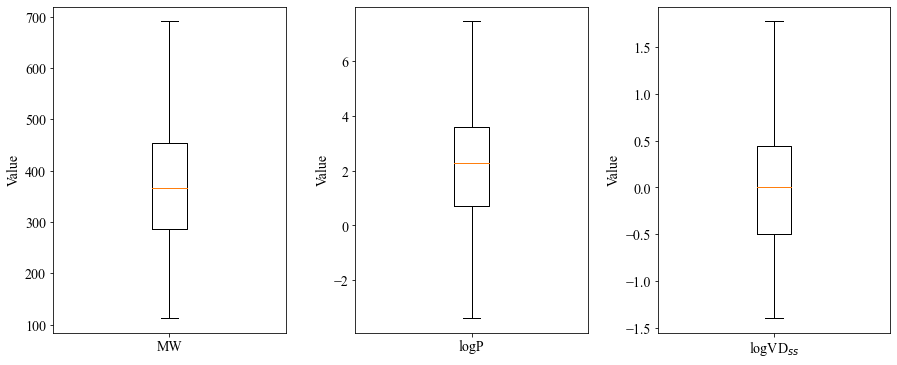

In [27]:
# boxplot after removing logVDss outliers
box(MW_LOGP_logVDss_delete)

In [28]:
# save file
MW_LOGP_logVDss_delete.to_excel("6_after_removing_outliers.xlsx", index=False)